In [1]:
import numpy as np
import PIL
import matplotlib.pyplot as plt  
import matplotlib.image as im   
from scipy import ndimage
import cv2 as cv
%matplotlib inline


filename = "M1.JPG"



In [2]:
src_image = cv.imread(filename)

img_gray = cv.cvtColor(src_image, cv.COLOR_BGR2GRAY)
img_array = np.array(img_gray)

print("Image shape: ", img_array.shape)

#plt.imshow(img_array, cmap='gray', vmin=0, vmax=255)

Image shape:  (300, 400)


In [3]:
cv.imshow("gray image", img_gray)
	
cv.waitKey(0)
cv.destroyAllWindows()

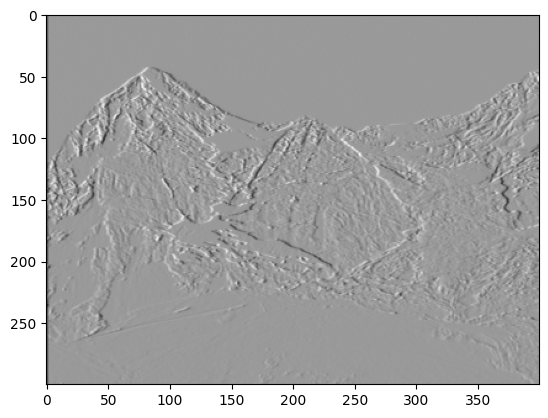

In [6]:

#Harris Corner Detection


# calcul des dérivées

#methode 1 : convolution avec masque
masqueX = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
masqueY =np.array([[-1,-2,-1], [0, 0, 0], [1, 2, 1]])

Ix = cv.filter2D(img_gray, -1, masqueX)
Iy = cv.filter2D(img_gray, -1, masqueY)



#methode 2 : gradient numpy

Ix_numpy, Iy_numpy = np.gradient(img_gray)

Ixx_numpy = Ix_numpy*Ix_numpy
Iyy_numpy = Iy_numpy*Iy_numpy
IxIy_numpy = Ix_numpy*Iy_numpy

plt.imshow(Iy_numpy, cmap='gray')



In [16]:
#convolution avec masque gaussien
sigma = 0.3
Gaussien_masque = np.array([[1,2,1],[2,4,2],[1,2,1]])

#Ix_array2 = cv.filter2D(np.array(Ix*Ix), -1, Gaussien_masque)
#Iy_array2 = cv.filter2D(np.array(Iy*Iy), -1, Gaussien_masque)
#IyIx_array = cv.filter2D(np.array(Ix*Iy), -1, Gaussien_masque)

Ix_array2 =  ndimage.gaussian_filter(np.array(Ix*Ix), sigma=sigma)
Iy_array2 =  ndimage.gaussian_filter(np.array(Iy*Iy), sigma=sigma)
IyIx_array =  ndimage.gaussian_filter(np.array(Ix*Iy), sigma=sigma)

In [17]:
k = 0.06
detM = Ix_array2*Iy_array2 - IyIx_array*IyIx_array
traceM = Ix_array2 + Iy_array2
C = detM - k*np.multiply(traceM,traceM)

print(C)


[[  0.     0.     0.   ...  -0.54  -0.24   0.  ]
 [  0.     0.     0.   ...  -2.94  -0.06   0.  ]
 [  0.     0.    -9.66 ... -11.76   0.     0.  ]
 ...
 [-11.76 -11.76   0.   ...   0.   -11.58  -0.24]
 [-13.5  -13.5   -0.96 ...  -3.84   0.     0.  ]
 [  0.     0.     0.   ...   0.    -0.24   0.  ]]


In [18]:
#seuillage avec ma0.0sque 
C_seuille = C>0


In [19]:
#detecter les indices des points d'interet

list_corners=[]
for i in range(C_seuille.shape[0]):
    for j in range(C_seuille.shape[1]):
        if C_seuille[i][j]==True:
            list_corners.append([i,j])

list_corners = np.array(list_corners)
print(list_corners.shape)


(27106, 2)


In [20]:
#afficher les points d'interet sur l'image

#copie de l'image
copy_img = cv.imread(filename)


for i in range(list_corners.shape[0]):
    copy_img[list_corners[i][0]][list_corners[i][1]] = [0,0,255]


cv.imshow("corners", copy_img)
cv.waitKey(0)
cv.destroyAllWindows()



In [21]:
#fast detector

def circle_around_pixel(img, i, j, seuil):
    #rend une liste des 16 pixels autour du pixel (i,j)
    # dans un rayon de 3 pixels

    list_pixels = []
    
    list_pixels.append(img[i-3][j])
    list_pixels.append(img[i-3][j+1])
    list_pixels.append(img[i-2][j+2])
    list_pixels.append(img[i-1][j+3
                                ])
    list_pixels.append(img[i][j+3])
    list_pixels.append(img[i+1][j+3])
    list_pixels.append(img[i+2][j+2])
    list_pixels.append(img[i+3][j+1])

    list_pixels.append(img[i+3][j])
    list_pixels.append(img[i+3][j-1])
    list_pixels.append(img[i+2][j-2])
    list_pixels.append(img[i+1][j-3])

    list_pixels.append(img[i][j-3])
    list_pixels.append(img[i-1][j-3])
    list_pixels.append(img[i-2][j-2])
    list_pixels.append(img[i-3][j-1])


    ref = img[i][j]
    for k in range(len(list_pixels)):
        if list_pixels[k]<ref-seuil or list_pixels[k]>ref+seuil:
            list_pixels[k]=1
        else:
            list_pixels[k]=0
    
    #liste pix est 2 octets
    
        

    return list_pixels



def detect_corner_FAST(seuil, img):
    #seuil : seuil de difference entre le pixel central et les pixels du cercle
    #img : image en niveau de gris
    #detecte les points d'interet avec la methode FAST
    #renvoie une liste des coordonnees des points d'interet
    
    list_corners = []
    
    for i in range(3, img.shape[0]-3):
        for j in range(3, img.shape[1]-3):
            #calculer la difference entre le pixel central et les pixels du cercle
            list_pixels = circle_around_pixel(img, i, j)
            diff = []
            for k in range(len(list_pixels)):
                diff.append(abs(img[i][j]-list_pixels[k]))
            #print(diff)
            #verifier si le pixel central est un point d'interet
            if max(diff)>seuil:
                list_corners.append([i,j])
    
    return np.array(list_corners)


In [22]:
#Test avec fonction déja implémentés
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
corners = cv.cornerHarris(gray,2,3,0.04)

img[corners>0.01*corners.max()]=[0,0,255]
cv.imshow('corners',img)

if cv.waitKey(0) & 0xff == 27:
 cv.destroyAllWindows()

#coordonnées des coins
corners = np.argwhere(corners>0.01*corners.max())

